In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import joblib
import re

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
import pandas as pd

file_path = '../data/agent_routing_dataset.csv'

try:
    # Try loading normally first
    df = pd.read_csv(file_path)
except pd.errors.ParserError as e:
    print(f"❌ ParserError encountered: {e}")
    print("🔁 Retrying with error-tolerant settings...")
    
    # Retry with engine='python' and skip bad lines
    df = pd.read_csv(file_path, engine='python', on_bad_lines='skip')

# Dataset Info
print(f"📊 Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"📋 Columns: {list(df.columns)}")

# Preview data
print("\n🔍 First 5 rows:")
print(df.head())

# Check class distribution
if 'agent' in df.columns:
    print(f"\n📈 Class distribution:")
    print(df['agent'].value_counts())
else:
    print("⚠️ Column 'agent' not found in dataset.")


❌ ParserError encountered: Error tokenizing data. C error: EOF inside string starting at row 2187
🔁 Retrying with error-tolerant settings...
📊 Dataset loaded: 2186 rows, 2 columns
📋 Columns: ['user_input', 'agent']

🔍 First 5 rows:
                                user_input            agent
0  How do I break this project into steps?    PlanningAgent
1                Give me a structured plan    PlanningAgent
2               Why didn't this code work?  ReflectionAgent
3             I want your thoughts on this  ReflectionAgent
4            What's the weather in Lahore?    ToolUserAgent

📈 Class distribution:
agent
ReflectionAgent    1135
PlanningAgent       579
ToolUserAgent       472
Name: count, dtype: int64


In [3]:
def clean_text(text):
    """Simple text cleaning function"""
    # Convert to lowercase
    text = text.lower()
    # Remove extra punctuation and spaces
    text = re.sub(r'[^\w\s\?]', ' ', text)
    text = ' '.join(text.split())
    return text

# Apply cleaning
df['clean_text'] = df['user_input'].apply(clean_text)

print("✅ Text preprocessing completed")


✅ Text preprocessing completed


In [4]:
# Features and target
X = df['clean_text']
y = df['agent']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"🔄 Data split completed:")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")


🔄 Data split completed:
   Training samples: 1748
   Test samples: 438


In [5]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=3000,      # Limit features for simplicity
        ngram_range=(1, 2),     # Use 1-word and 2-word phrases
        stop_words='english'    # Remove common words
    )),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000
    ))
])

print("🚀 Training model...")

# Train the model
model.fit(X_train, y_train)

print("✅ Model training completed!")

🚀 Training model...
✅ Model training completed!


In [6]:
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"🎯 Model Accuracy: {accuracy:.3f}")

# Detailed classification report
print("\n📊 Detailed Results:")
print(classification_report(y_test, y_pred))


🎯 Model Accuracy: 0.991

📊 Detailed Results:
                 precision    recall  f1-score   support

  PlanningAgent       0.99      0.97      0.98       116
ReflectionAgent       1.00      1.00      1.00       227
  ToolUserAgent       0.98      1.00      0.99        95

       accuracy                           0.99       438
      macro avg       0.99      0.99      0.99       438
   weighted avg       0.99      0.99      0.99       438



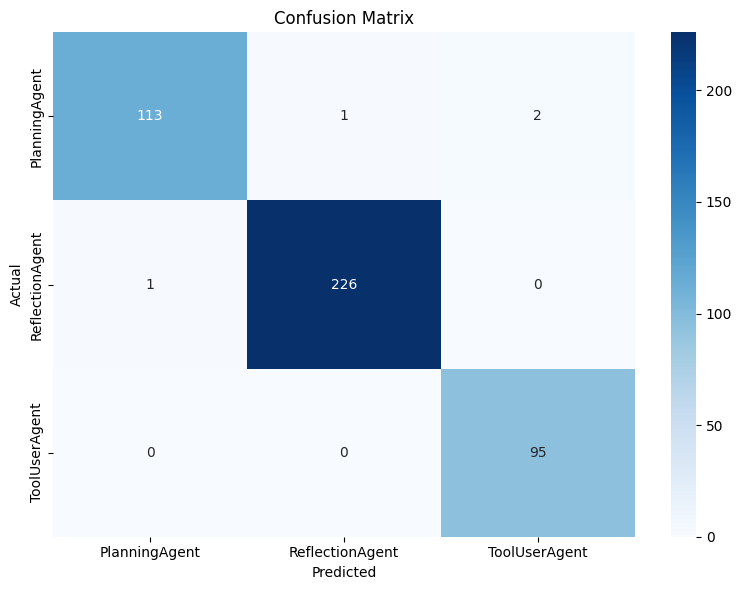

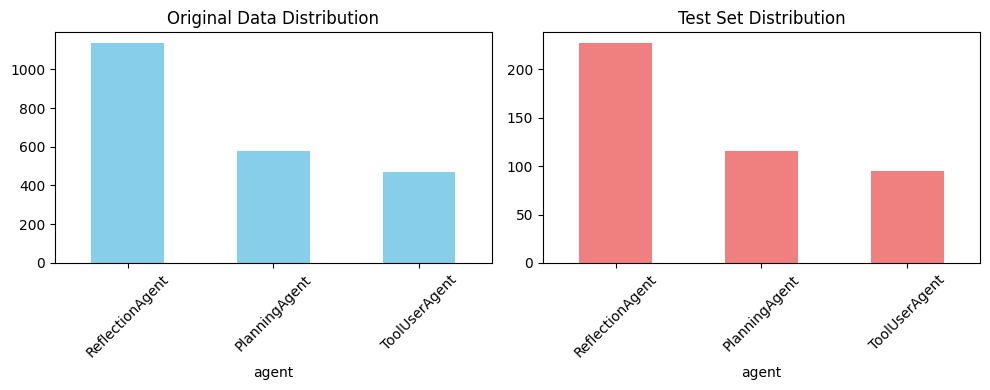

In [7]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Show class distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
df['agent'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Original Data Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
pd.Series(y_test).value_counts().plot(kind='bar', color='lightcoral')
plt.title('Test Set Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [8]:
def predict_agent(text):
    """Simple prediction function"""
    prediction = model.predict([text])[0]
    probabilities = model.predict_proba([text])[0]
    
    # Get all class probabilities
    prob_dict = {}
    for i, class_name in enumerate(model.classes_):
        prob_dict[class_name] = probabilities[i]
    
    confidence = probabilities.max()
    
    return prediction, confidence, prob_dict

# Test examples
test_examples = [
    "How should I organize my project schedule?",
    "What went wrong with my approach?", 
    "Calculate 25 times 48",
    "I need help planning my day",
    "Can you analyze what happened?",
    "What's the weather today?"
]

print("\n🧪 Testing model with examples:")
print("=" * 60)

for example in test_examples:
    agent, confidence, all_probs = predict_agent(example)
    
    print(f"\nInput: '{example}'")
    print(f"→ Predicted: {agent}")
    print(f"→ Confidence: {confidence:.3f}")
    
    # Show top 2 most likely agents
    sorted_probs = sorted(all_probs.items(), key=lambda x: x[1], reverse=True)
    print(f"→ Top predictions:")
    for i, (class_name, prob) in enumerate(sorted_probs[:2]):
        print(f"   {i+1}. {class_name}: {prob:.3f}")



🧪 Testing model with examples:

Input: 'How should I organize my project schedule?'
→ Predicted: PlanningAgent
→ Confidence: 0.730
→ Top predictions:
   1. PlanningAgent: 0.730
   2. ToolUserAgent: 0.175

Input: 'What went wrong with my approach?'
→ Predicted: ReflectionAgent
→ Confidence: 0.740
→ Top predictions:
   1. ReflectionAgent: 0.740
   2. ToolUserAgent: 0.132

Input: 'Calculate 25 times 48'
→ Predicted: ToolUserAgent
→ Confidence: 0.904
→ Top predictions:
   1. ToolUserAgent: 0.904
   2. ReflectionAgent: 0.050

Input: 'I need help planning my day'
→ Predicted: PlanningAgent
→ Confidence: 0.766
→ Top predictions:
   1. PlanningAgent: 0.766
   2. ReflectionAgent: 0.137

Input: 'Can you analyze what happened?'
→ Predicted: ReflectionAgent
→ Confidence: 0.768
→ Top predictions:
   1. ReflectionAgent: 0.768
   2. ToolUserAgent: 0.155

Input: 'What's the weather today?'
→ Predicted: ToolUserAgent
→ Confidence: 0.872
→ Top predictions:
   1. ToolUserAgent: 0.872
   2. ReflectionAge

In [9]:
model_filename = '../model/simple_agent_classifier.pkl'
joblib.dump(model, model_filename)

print(f"\n💾 Model saved as '{model_filename}'")


💾 Model saved as '../model/simple_agent_classifier.pkl'


In [10]:
def load_model_and_predict(text, model_file='../model/simple_agent_classifier.pkl'):
    """Load saved model and make prediction"""
    try:
        loaded_model = joblib.load(model_file)
        prediction = loaded_model.predict([text])[0]
        confidence = loaded_model.predict_proba([text])[0].max()
        return prediction, confidence
    except FileNotFoundError:
        return "Error: Model file not found", 0.0

# Test loading the saved model
test_text = "Help me create a project timeline"
predicted_agent, conf = load_model_and_predict(test_text)

print(f"\n🔄 Testing saved model:")
print(f"Input: '{test_text}'")
print(f"Result: {predicted_agent} (confidence: {conf:.3f})")



🔄 Testing saved model:
Input: 'Help me create a project timeline'
Result: PlanningAgent (confidence: 0.742)


In [11]:
class SimpleAgentClassifier:
    """Easy-to-use agent classifier"""
    
    def __init__(self, model_path='../model/simple_agent_classifier.pkl'):
        self.model = joblib.load(model_path)
        
    def classify(self, text):
        """Classify a single text input"""
        prediction = self.model.predict([text])[0]
        probabilities = self.model.predict_proba([text])[0]
        confidence = probabilities.max()
        
        return {
            'agent': prediction,
            'confidence': confidence,
            'reliable': confidence > 0.7
        }
    
    def classify_batch(self, texts):
        """Classify multiple texts at once"""
        predictions = self.model.predict(texts)
        probabilities = self.model.predict_proba(texts)
        
        results = []
        for i, text in enumerate(texts):
            results.append({
                'text': text,
                'agent': predictions[i],
                'confidence': probabilities[i].max(),
                'reliable': probabilities[i].max() > 0.7
            })
        
        return results

# Example usage of the production class
print("\n🏭 Production-ready classifier example:")

try:
    classifier = SimpleAgentClassifier()
    
    # Single prediction
    result = classifier.classify("How do I plan my workflow?")
    print(f"Single prediction: {result}")
    
    # Batch prediction
    batch_texts = [
        "Help me organize this",
        "What do you think about this?",
        "Calculate the sum of 25 and 75"
    ]
    
    batch_results = classifier.classify_batch(batch_texts)
    print(f"\nBatch predictions:")
    for result in batch_results:
        print(f"  '{result['text'][:30]}...' → {result['agent']} ({result['confidence']:.3f})")

except FileNotFoundError:
    print("Model file not found - make sure to run the training section first!")



🏭 Production-ready classifier example:
Single prediction: {'agent': 'PlanningAgent', 'confidence': np.float64(0.8433909149655374), 'reliable': np.True_}

Batch predictions:
  'Help me organize this...' → PlanningAgent (0.911)
  'What do you think about this?...' → ReflectionAgent (0.876)
  'Calculate the sum of 25 and 75...' → ToolUserAgent (0.879)


In [12]:
print("\n" + "="*60)
print("🎉 TRAINING COMPLETED!")
print("="*60)
print(f"📊 Final Accuracy: {accuracy:.3f}")
print(f"💾 Model saved as: {model_filename}")
print(f"🔧 Model type: Logistic Regression + TF-IDF")
print(f"📝 Features: {model.named_steps['tfidf'].max_features} TF-IDF features")

print(f"\n📋 Quick Usage:")
print(f"   from joblib import load")
print(f"   model = load('{model_filename}')")
print(f"   prediction = model.predict(['your text here'])[0]")

print(f"\n✅ Ready for production use!")
print("="*60)


🎉 TRAINING COMPLETED!
📊 Final Accuracy: 0.991
💾 Model saved as: ../model/simple_agent_classifier.pkl
🔧 Model type: Logistic Regression + TF-IDF
📝 Features: 3000 TF-IDF features

📋 Quick Usage:
   from joblib import load
   model = load('../model/simple_agent_classifier.pkl')
   prediction = model.predict(['your text here'])[0]

✅ Ready for production use!


In [13]:
def quick_accuracy_test():
    """Quick test to verify model is working correctly"""
    
    # Test cases that should be easy to classify
    easy_tests = [
        ("How do I organize my schedule?", "PlanningAgent"),
        ("What went wrong here?", "ReflectionAgent"), 
        ("Calculate 5 plus 5", "ToolUserAgent")
    ]
    
    correct = 0
    total = len(easy_tests)
    
    print(f"\n🧪 Quick Accuracy Test:")
    for text, expected in easy_tests:
        predicted, conf = load_model_and_predict(text)
        is_correct = predicted == expected
        correct += is_correct
        
        status = "✅" if is_correct else "❌"
        print(f"{status} '{text}' → {predicted} (expected: {expected})")
    
    print(f"\n📊 Quick Test Accuracy: {correct}/{total} = {correct/total:.3f}")

quick_accuracy_test()

print(f"\n🎯 All done! Your simple agent classifier is ready to use.")




🧪 Quick Accuracy Test:
✅ 'How do I organize my schedule?' → PlanningAgent (expected: PlanningAgent)
✅ 'What went wrong here?' → ReflectionAgent (expected: ReflectionAgent)
✅ 'Calculate 5 plus 5' → ToolUserAgent (expected: ToolUserAgent)

📊 Quick Test Accuracy: 3/3 = 1.000

🎯 All done! Your simple agent classifier is ready to use.
